In [14]:
using Flux, Plots
using ChainRulesCore
using Statistics
using Random
using MDToolbox
using BenchmarkTools
using EzXML
using LinearAlgebra
using SparseArrays
using Dates
using Distributed
using FiniteDifferences
using CUDA
using CUDA.Adapt

ENV["COLUMNS"] = 130

130

In [1]:
#このノートブックは未完成

In [ ]:
pdb_filepath = "./alanine-dipeptide-nowater.pdb"
traj_dir = "./sim_dihedral/"
ff_dir = "./sim_dihedral/"
njobs = 4

target_traj_path = "./target/sim_target.dcd"
target_ff_filepath = "./data/amber14/protein.ff14SB.xml" 

In [4]:
slice = 1000 # データのスライス
atom_list = [5 17] #距離を計算する原子のペア
num_points = 50

atom_pairs = []
for i in 1:length(atom_list)
    for j in i+1:length(atom_list)
        push!(atom_pairs, [atom_list[i] atom_list[j]])
    end
end

In [5]:
#pythonのmdtrajのインデックスに+1してる
phi_indices = [5, 7, 9, 15]   #二面角ϕ
psi_indices = [7, 9, 15, 17]  #二面角ψ

#xmlファイルでのatom type
phi_atom_type = ["C", "N", "CT", "C"]
psi_atom_type = ["N", "CT", "C", "N"]

4-element Vector{String}:
 "N"
 "CT"
 "C"
 "N"

In [6]:
function safe_acos(x::Float64)
    # xの値を[-1, 1]の範囲にクランプする
    return acos(clamp(x, -1.0, 1.0))
end

function _compute_dihedral(ta1::TrjArray{T, U}, ta2::TrjArray{T, U}, ta3::TrjArray{T, U}, ta4::TrjArray{T, U})::Vector{T} where {T, U}
    nframe = ta1.nframe
    com1 = centerofmass(ta1, isweight=true)
    com2 = centerofmass(ta2, isweight=true)
    com3 = centerofmass(ta3, isweight=true)
    com4 = centerofmass(ta4, isweight=true)
    a = zeros(T, nframe)
    # Threads.@threads for iframe in 1:nframe
    for iframe in 1:nframe
        d1 = [com1.xyz[iframe, 1] - com2.xyz[iframe, 1]; com1.xyz[iframe, 2] - com2.xyz[iframe, 2]; com1.xyz[iframe, 3] - com2.xyz[iframe, 3]]
        d2 = [com3.xyz[iframe, 1] - com2.xyz[iframe, 1]; com3.xyz[iframe, 2] - com2.xyz[iframe, 2]; com3.xyz[iframe, 3] - com2.xyz[iframe, 3]]
        d3 = [com3.xyz[iframe, 1] - com4.xyz[iframe, 1]; com3.xyz[iframe, 2] - com4.xyz[iframe, 2]; com3.xyz[iframe, 3] - com4.xyz[iframe, 3]]
        m1 = cross(d1, d2)
        m2 = cross(d2, d3)
        a[iframe] = safe_acos(dot(m1, m2)/(norm(m1)*norm(m2)))
        rotdirection = dot(d2,cross(m1,m2))
        if rotdirection < zero(T)
            a[iframe] = -a[iframe]
        end
    end
    a .= (a ./ pi) .* T(180)
end

_compute_dihedral (generic function with 1 method)

In [7]:
top = readpdb(pdb_filepath)

ta = mdload(target_traj_path)
ta = ta[1:slice:end]

phi = _compute_dihedral(ta[:,phi_indices[1]], ta[:,phi_indices[2]], ta[:,phi_indices[3]], ta[:,phi_indices[4]]) * π / 180
psi = _compute_dihedral(ta[:,psi_indices[1]], ta[:,psi_indices[2]], ta[:,psi_indices[3]], ta[:,psi_indices[4]]) * π / 180
dihedral_target = hcat(phi, psi)

distance_target = []
for i in 1:length(atom_pairs)
    d = compute_distance(ta, atom_pairs[i]) ./ 10
    push!(distance_target, d)
end
distance_target = hcat(distance_target...)

10000×1 Matrix{Float64}:
 0.42302405828552364
 0.4222730617119268
 0.3896510462791506
 0.4389968746607142
 0.44135815944330126
 0.3441327966289471
 0.445081216623724
 0.47832754206525285
 0.410907999874816
 0.48968711271259646
 0.3428351200712834
 0.3246809817852856
 0.33208604395107644
 ⋮
 0.45859723246986783
 0.31557875856904005
 0.32975489516287304
 0.4641305759624797
 0.32907007861504955
 0.441641825471191
 0.42293844241689255
 0.34268777872010003
 0.4399082697032336
 0.425557212823915
 0.4440864749798812
 0.44302165731179705

In [8]:
function kde_estimate(data::AbstractArray; 
                    weight::AbstractArray = ones(length(data)), 
                    bandwidth=0.0, 
                    num_points::Int=1000, 
                    x_grid::AbstractVector=[])
    # If bandwidth is not specified, estimate it using Silverman's rule
    if bandwidth == 0.0
        n = length(data)
        s = std(data)
        IQR = quantile(data, 0.75) - quantile(data, 0.25)
        @show bandwidth = 0.9 * min(s, IQR / 1.34) / n^(1/5)
    end
    
    # Compute kernel density estimate
    if isempty(x_grid)
        x_grid = range(minimum(data), maximum(data), length=num_points) |> Vector
    end
    
    density_estimate = zeros(num_points)
    for i in 1:num_points
        x = x_grid[i]
        kernel_sum = 0.0
        for (val, w) in zip(data, weight)
            kernel_sum += w * exp(-((x - val) / bandwidth)^2 / 2) / sqrt(2 * π)
        end
        density_estimate[i] = kernel_sum / sum(weight) / bandwidth
    end
    
    return x_grid, density_estimate
end

kde_estimate (generic function with 1 method)

In [16]:
distance_target = vec(distance_target)

10000-element CuArray{Float64, 1, CUDA.Mem.DeviceBuffer}:
 0.42302405828552364
 0.4222730617119268
 0.3896510462791506
 0.4389968746607142
 0.44135815944330126
 0.3441327966289471
 0.445081216623724
 0.47832754206525285
 0.410907999874816
 0.48968711271259646
 0.3428351200712834
 0.3246809817852856
 0.33208604395107644
 ⋮
 0.45859723246986783
 0.31557875856904005
 0.32975489516287304
 0.4641305759624797
 0.32907007861504955
 0.441641825471191
 0.42293844241689255
 0.34268777872010003
 0.4399082697032336
 0.425557212823915
 0.4440864749798812
 0.44302165731179705

bandwidth = (0.9 * min(s, IQR / 1.34)) / n ^ (1 / 5) = 0.007868692559329867
  0.228937 seconds (6.06 M allocations: 96.264 MiB, 7.28% gc time, 47.47% compilation time)


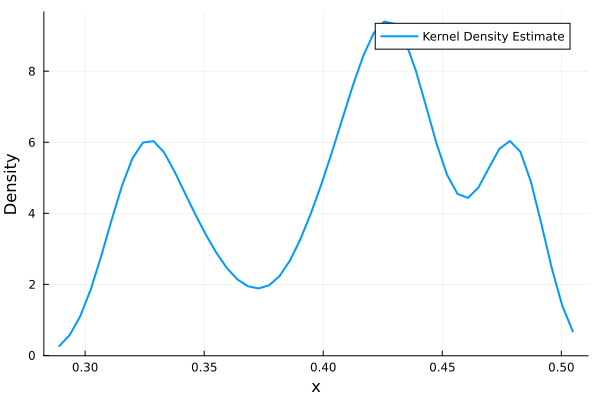

In [10]:
@time x_grid, density_estimate = kde_estimate(vec(distance_target), num_points=num_points)
plot(x_grid, density_estimate, label="Kernel Density Estimate", xlabel="x", ylabel="Density", linewidth=2)

#output
#bandwidth = (0.9 * min(s, IQR / 1.34)) / n ^ (1 / 5) = 0.002344544760038454
#190.121109 seconds (12.00 G allocations: 179.040 GiB, 1.35% gc time, 0.04% compilation time)

In [11]:
bandwidth  = 0.007868692559329867

0.007868692559329867

In [20]:
function kde_estimate_gpu(data::CuArray{T};
                            weight::CuArray{T}=adapt(CuArray, ones(T, length(data))), 
                            bandwidth::T=0.0, 
                            num_points::Int=1000, 
                            x_grid::CuArray{T}=adapt(CuArray, Float64[])) where {T}
    
    # If bandwidth is not specified, estimate it using Silverman's rule
    if bandwidth == 0.0
        n = length(data)
        s = std(data)
        IQR = quantile_range(data)
        bandwidth = T(0.9) * min(s, IQR / T(1.34)) / n^(T(1)/5)
    end
    
    # Compute kernel density estimate on the GPU
    if isempty(x_grid)
        x_min = minimum(data)
        x_max = maximum(data)
        x_grid = CuArray(range(T(x_min), T(x_max), length=num_points))
    end
  
    density_estimate = similar(x_grid)
    nthreads = num_points
    nblocks = ceil(Int, num_points / nthreads)
    @cuda threads=nthreads blocks=nblocks kde_estimate_kernel!(data, weight, bandwidth, density_estimate, x_grid)
    
    return x_grid, density_estimate
end

kde_estimate_gpu (generic function with 2 methods)

In [12]:
function kde_estimate_gpu(data_k::AbstractArray{<:CuArray},
                            weight_k::AbstractArray{<:CuArray{T}}; 
                            bandwidth::T=0.0, 
                            num_points::Int=1000, 
                            x_grid::CuArray{T}=adapt(CuArray, Float64[])) where {T}

    K = length(data_k)
    N_k = Array{Int}(undef, K)
    for k in 1:K
        N_k[k] = length(data_k[k])
    end
    
    data = vcat(data_k...)
    weight = vcat(weight_k...)
    # If bandwidth is not specified, estimate it using Silverman's rule
    if bandwidth == 0.0
        n = length(data)
        s = std(data)
        IQR = quantile_range(data)
        bandwidth = T(0.9) * min(s, IQR / T(1.34)) / n^(T(1)/5)
    end
    
    # Compute kernel density estimate on the GPU
    if isempty(x_grid)
        x_min = minimum(data)
        x_max = maximum(data)
        x_grid = CuArray(range(T(x_min), T(x_max), length=num_points))
    end
  
    density_estimate = similar(x_grid)
    nthreads = num_points
    nblocks = ceil(Int, num_points / nthreads)
    @cuda threads=nthreads blocks=nblocks kde_estimate_kernel!(data, weight, bandwidth, density_estimate, x_grid)
    return density_estimate
end

# Define CUDA kernel function
function kde_estimate_kernel!(data::CuDeviceArray{T}, 
                          weight::CuDeviceArray{T}, 
                          bandwidth::T, 
                          density_estimate::CuDeviceArray{T},
                          x_grid::CuDeviceArray{T}) where {T}
    index = threadIdx().x
    stride = blockDim().x
    
    n = length(data)
    num_points = length(x_grid)
    
    for i = index:stride:num_points
        x = x_grid[i]
        kernel_sum = T(0)
        for j = 1:n
            kernel_sum += weight[j] * exp(-((x - data[j]) / bandwidth)^2 / T(2)) / sqrt(T(2 * π))
        end
        density_estimate[i] = kernel_sum / sum(weight) / bandwidth
    end
    return nothing
end

function ChainRulesCore.rrule(::typeof(kde_estimate_gpu), data_k::AbstractArray{<:CuArray},
                            weight_k::AbstractArray{<:CuArray{T}}; 
                            bandwidth::T=0.0, 
                            num_points::Int=1000, 
                            x_grid::CuArray{T}=adapt(CuArray, Float64[])) where {T}

    K = length(data_k)
    N_k = Array{Int}(undef, K)
    for k in 1:K
        N_k[k] = length(data_k[k])
    end
    
    data = vcat(data_k...)
    weight = vcat(weight_k...)
    # If bandwidth is not specified, estimate it using Silverman's rule
    if bandwidth == 0.0
        n = length(data)
        s = std(data)
        IQR = quantile_range(data)
        bandwidth = T(0.9) * min(s, IQR / T(1.34)) / n^(T(1)/5)
    end
    
    density_estimate = similar(x_grid)
    nthreads = num_points
    nblocks = ceil(Int, num_points / nthreads)
    @cuda threads=nthreads blocks=nblocks kde_estimate_kernel!(data, weight, bandwidth, density_estimate, x_grid)
    
    function kde_estimate_pullback(dU)
        K = length(data_k)
        N_k = Array{Int}(undef, K)
        for k in 1:K
            N_k[k] = length(data_k[k])
        end

        data = vcat(data_k...)
        weight = vcat(weight_k...)
        
        dweight_k = similar(weight_k)
        dweight = similar(weight)
        
        nthreads = num_points
        nblocks = ceil(Int, num_points / nthreads)
        @cuda threads=nthreads blocks=nblocks kde_estimate_pullback_aux!(data, weight, bandwidth, num_points, x_grid, dweight, dU)
        
        index_start = 1
        for k in 1:K
            index_end = index_start + N_k[k] - 1
            dweight_k[k] = dweight[index_start:index_end]
            index_start = index_end + 1
        end
        return NoTangent(), NoTangent(), dweight_k, NoTangent(), NoTangent(), NoTangent()
    end
    return density_estimate , kde_estimate_pullback
end

function kde_estimate_pullback_aux!(data::CuDeviceArray{T}, weight::CuDeviceArray{T},
                                    bandwidth::T,
                                    num_points::Int,
                                    x_grid::CuDeviceArray{T},
                                    dweight::CuDeviceArray{T},
                                    dU::CuDeviceArray{T}) where {T}

    index = threadIdx().x
    stride = blockDim().x
    n = length(data)
    for i in index:stride:num_points
        for j in 1:n
            dweight[j] += exp(-((x_grid[i] - data[j]) / bandwidth)^2 / 2.0 ) / (bandwidth * sqrt(2 * π)) * dU[i]
        end
    end
    return nothing
end

function quantile_range(data::CuArray{T}) where T
    n = length(data)
    sorted_data = sort(data)
    q1_index = Int(ceil(0.25 * n))
    q3_index = Int(floor(0.75 * n))
    CUDA.allowscalar() do
        q1 = sorted_data[q1_index]
        q3 = sorted_data[q3_index]
        return q3 - q1
    end
end

quantile_range (generic function with 1 method)

In [21]:
methods(kde_estimate_gpu)

# 2 methods for generic function "kde_estimate_gpu" from Main:
 [1] kde_estimate_gpu(data::CuArray{T}; weight, bandwidth, num_points, x_grid) where T
     @ In[20]:1
 [2] kde_estimate_gpu(data_k::AbstractArray{<:CuArray}, weight_k::AbstractArray{<:CuArray{T}}; bandwidth, num_points, x_grid) where T
     @ In[12]:1

 13.931060 seconds (12.86 M allocations: 890.485 MiB, 6.09% gc time, 97.53% compilation time: 4% of which was recompilation)


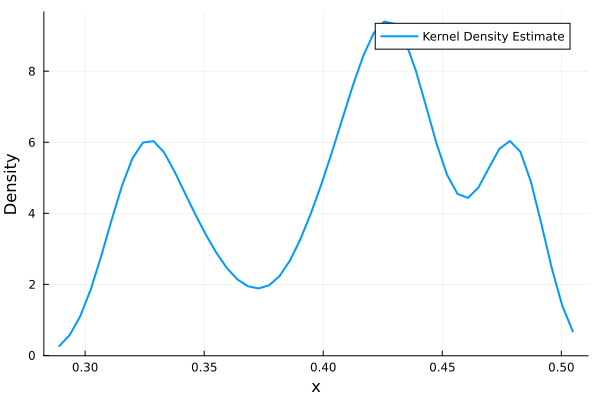

In [22]:
x_grid = adapt(CuArray, x_grid)
distance_target = adapt(CuArray, distance_target)
@time x_grid, density_estimate = kde_estimate_gpu(distance_target, x_grid=x_grid, bandwidth=bandwidth, num_points=num_points)
plot(x_grid |> cpu, density_estimate |> cpu, label="Kernel Density Estimate", xlabel="x", ylabel="Density", linewidth=2)

In [18]:
dihedral_k = Array{Array{Float64}}(undef, njobs)
distance_k = Array{Array{Float64}}(undef, njobs)

for i in 1:njobs
    traj_filepath = joinpath(traj_dir, "sim$(i)/traj_$(i).dcd")
    ta = mdload(traj_filepath, top=top)

    ta = ta[1:slice:end]
    phi = compute_dihedral(ta[:,phi_indices[1]], ta[:,phi_indices[2]], ta[:,phi_indices[3]], ta[:,phi_indices[4]]) * π / 180
    psi = compute_dihedral(ta[:,psi_indices[1]], ta[:,psi_indices[2]], ta[:,psi_indices[3]], ta[:,psi_indices[4]]) * π / 180
    dihedral_k[i] = hcat(phi, psi)

    distance = []
    for i in 1:length(atom_pairs)
        d = compute_distance(ta, atom_pairs[i]) ./ 10
        push!(distance, d)
    end
    distance_k[i] = vec(hcat(distance...))
end

In [ ]:
using Plots
using Statistics  # 標準偏差やその他統計量のために使用

# 2Dカーネル密度推定とPMFを計算する関数
function calculate_pmf(x_data::Vector{<:Real}, y_data::Vector{<:Real}, grid_size::Int=100)
    # グリッドの生成
    x_grid = range(-π, stop=π, length=grid_size)
    y_grid = range(-π, stop=π, length=grid_size)

    # カーネル密度推定のバンド幅（スコットのルールを使用）
    hx = 1.06 * std(x_data) * length(x_data)^(-1/5)  # xのバンド幅
    hy = 1.06 * std(y_data) * length(y_data)^(-1/5)  # yのバンド幅

    # カーネル関数（ガウスカーネル）
    function gaussian_kernel(u)
        return exp(-0.5 * u^2) / sqrt(2 * π)
    end

    # カーネル密度推定の計算
    density = zeros(grid_size, grid_size)
    for i in 1:grid_size
        for j in 1:grid_size
            xi, yj = x_grid[i], y_grid[j]
            sum_k = 0.0
            for k in 1:length(x_data)
                sum_k += gaussian_kernel((xi - x_data[k]) / hx) * gaussian_kernel((yj - y_data[k]) / hy)
            end
            density[i, j] = sum_k / (length(x_data) * hx * hy)
        end
    end

    return x_grid, y_grid, density
end

# PMFの等高線プロットを作成
function plot_pmf_contour(x_grid, y_grid, pmf; title="PMF")
    # カラーマップの設定：閾値以上を白に設定
    
    # viridisの色を手動で指定
    viridis_colors = [
        RGB(0.267, 0.004, 0.329),
        RGB(0.283, 0.141, 0.458),
        RGB(0.254, 0.265, 0.530),
        RGB(0.207, 0.372, 0.553),
        RGB(0.164, 0.471, 0.558),
        RGB(0.128, 0.567, 0.551),
        RGB(0.136, 0.659, 0.517),
        RGB(0.267, 0.749, 0.441),
        RGB(0.478, 0.821, 0.318),
        RGB(0.741, 0.873, 0.150),
        RGB(0.993, 0.906, 0.144)
    ]
    
    # 最後に白色を追加
    extended_colors = vcat(viridis_colors, [RGB(1.0, 1.0, 1.0)])
    
    # カスタムカラーマップを作成
    extended_cmap = cgrad(extended_colors)
    
    # このカラーマップを使ってプロット
    # 例: contourf(x_grid, y_grid, data, color=extended_cmap)
    
    # カラーマップの範囲を設定
    threshold = 1e-8
    log_pmf = -log10.(pmf.+threshold)
    clims = (minimum(log_pmf), threshold)
    contourf(x_grid, y_grid, log_pmf, color=extended_cmap, colorbar=true, levels=10)
    title!(title)
    xlabel!("Phi")
    ylabel!("Psi")
end

In [ ]:
p = []
for k in 1:length(dihedral_k)
    # データの準備
    x_data = dihedral_target_k[k][1:400:end, 2]
    y_data = dihedral_target_k[k][1:400:end, 1]
    
    # PMFの計算
    x_grid, y_grid, pmf = calculate_pmf(x_data, y_data)
    tmp = plot_pmf_contour(x_grid, y_grid, pmf, title="k=$(k)")
    push!(p, tmp)
end
plot(p..., layout=(4, 3), size=(800, 600))

In [ ]:
p = []
for k in 1:length(dihedral_k)
    # データの準備
    x_data = dihedral_k[k][1:1:end, 2]
    y_data = dihedral_k[k][1:1:end, 1]
    
    # PMFの計算
    x_grid, y_grid, pmf = calculate_pmf(x_data, y_data)
    tmp = plot_pmf_contour(x_grid, y_grid, pmf, title="k=$(k)")
    push!(p, tmp)
end
plot(p..., layout=(3, 4), size=(800, 600))

In [19]:
#二面角ϕ,ψに関連するパラメータはn,θ_zero,kの３つ
#最適化を目指すのはk

abstract type AbstractParam end

struct ParamCPU{T<:AbstractFloat}<:AbstractParam
    n::Vector{T}
    theta_zero::Vector{T}
    k::Vector{T}
end

struct Param{T<:AbstractFloat}<:AbstractParam
    n::CuArray{T}
    theta_zero::CuArray{T}
    k::CuArray{T}
end

function init_Param(ff_array::AbstractVector, gpu::Bool=false, T::DataType=Float64)
    n = T[]
    theta_zero = T[]
    k = T[]
    
    for line in ff_array
        #println(line)      
        if(occursin(r"type.*", line[1]))
            continue
        elseif(occursin(r"periodicity.*", line[1]))
            push!(n, parse(T, line[2]))
        elseif(occursin(r"phase.*", line[1]))
            push!(theta_zero, parse(T, line[2]))
        elseif(occursin(r"k.*", line[1]))
            push!(k, parse(T, line[2]))
        else
            println("ERROR")
        end
    end
    
    if(gpu) 
        n = adapt(CuArray, n)
        theta_zero = adapt(CuArray, theta_zero)
        k = adapt(CuArray, k)
        ff_param = Param(n, theta_zero, k)
        return ff_param
    end
    
    ff_param = ParamCPU(n, theta_zero, k)
    return ff_param
end

init_Param (generic function with 3 methods)

In [20]:
#力場ファイルから対象のパラメータを返す関数
function input_ff(ff_filepath; gpu=false::Bool)
    xml = readxml(ff_filepath)
    xmlroot = root(xml)
    
    children = elements(xmlroot)
    children_name = nodename.(children)
    torsion_index = children_name .== "PeriodicTorsionForce"
    torsion = children[torsion_index][1]
    
    #phi_atom_type = ["C", "N", "CT", "C"]
    #psi_atom_type = ["N", "CT", "C", "N"]
    phi_atom_type = ["protein-C", "protein-N", "protein-CX", "protein-C"]
    psi_atom_type = ["protein-N", "protein-CX", "protein-C", "protein-N"]
    
    ff_phi = []
    ff_psi = []
    for ff_params in eachelement(torsion)
        params_name = [nodename(i) for i in eachattribute(ff_params)]
        params_content = [nodecontent(i) for i in eachattribute(ff_params)]
        atom_type = [params_content[params_name .== "type$(i)"][1] for i in 1:4]
        #println(atom_type)
        if(atom_type == phi_atom_type)
            ff_phi = [(params_name[i], params_content[i]) for i in 1:length(params_name)]
        end
        if(atom_type == psi_atom_type)
            ff_psi = [(params_name[i], params_content[i]) for i in 1:length(params_name)]
        end
    end
    return init_Param(ff_phi, gpu), init_Param(ff_psi, gpu)
end

input_ff (generic function with 1 method)

In [21]:
ff_phi_k = Array{ParamCPU}(undef, njobs)
ff_psi_k = Array{ParamCPU}(undef, njobs)

for i in 1:njobs
    ff_filepath = joinpath(ff_dir, "sim$(i)/sim_$(i).xml")
    ff_phi_k[i], ff_psi_k[i] = input_ff(ff_filepath)
end

#input target ff
ff_phi_target, ff_psi_target = input_ff(target_ff_filepath, gpu=true)

(Param{Float64}([4.0, 3.0, 2.0, 1.0], [0.0, 0.0, 0.0, 0.0], [0.0, 1.5912124480913628, 0.5758296657363305, 0.0]), Param{Float64}([4.0, 3.0, 2.0, 1.0], [0.0, 3.141592653589793, 3.141592653589793, 3.141592653589793], [0.0, 2.392428654874814, 6.788397193281365, 1.775556612249427]))

In [22]:
#二面角のポテンシャルの計算
@inline function compute_dihedral_energy(theta::AbstractFloat, n::AbstractFloat, 
        theta_zero::AbstractFloat, k::AbstractFloat)
    return k * (1 + cos(n * theta - theta_zero))
end

function sum_compute_dihedral_energy(theta::AbstractFloat, ff_param::AbstractParam)
    return sum(compute_dihedral_energy.(theta, ff_param.n, ff_param.theta_zero, ff_param.k))
end

sum_compute_dihedral_energy (generic function with 1 method)

In [23]:
#compute u_kl
K = njobs
N_k = Array{Int}(undef, K)
for k in 1:K
    N_k[k] = length(distance_k[k])
end
KBT = KB_kcalpermol * 300
beta = Float64(1.0/(KBT))

u_kl = Array{Array{Float64}}(undef, (K, K))
for k in 1:K
    for l in 1:K
        u_kl[k, l] = map(i -> beta * sum_compute_dihedral_energy(dihedral_k[k][i, 1], ff_phi_k[l]) 
            + beta * sum_compute_dihedral_energy(dihedral_k[k][i, 2], ff_psi_k[l]), 1:N_k[k])
    end
end

In [24]:
f_k = Float64.(MDToolbox.mbar(u_kl))

iteration = 1  delta = 1.725024e+00  tol = 1.000000e-08
free energies =  0.000000 0.069101 0.305377 -1.187260 -1.318920

iteration = 2  delta = 4.144146e-01  tol = 1.000000e-08
free energies =  0.000000 -0.071080 0.279098 -1.458423 -1.698490

iteration = 3  delta = 1.291266e-01  tol = 1.000000e-08
free energies =  0.000000 -0.130141 0.264767 -1.549175 -1.822910

iteration = 4  delta = 4.333943e-02  tol = 1.000000e-08
free energies =  0.000000 -0.151883 0.259200 -1.580537 -1.865367

iteration = 5  delta = 1.492636e-02  tol = 1.000000e-08
free energies =  0.000000 -0.159613 0.257187 -1.591447 -1.880072

iteration = 6  delta = 5.186274e-03  tol = 1.000000e-08
free energies =  0.000000 -0.162329 0.256476 -1.595250 -1.885192

iteration = 7  delta = 1.807484e-03  tol = 1.000000e-08
free energies =  0.000000 -0.163280 0.256226 -1.596577 -1.886977

iteration = 8  delta = 6.305921e-04  tol = 1.000000e-08
free energies =  0.000000 -0.163612 0.256139 -1.597040 -1.887600

iteration = 9  delta = 2.

5-element Vector{Float64}:
  0.0
 -0.163790211679539
  0.2560919215341328
 -1.597288819517157
 -1.8879340283422839

In [25]:
dihedral_k = adapt(Vector{CuArray}, dihedral_k)
distance_k = adapt(Vector{CuArray}, distance_k)
dihedral_target = adapt(CuArray, dihedral_target)
distance_target = adapt(CuArray, distance_target)

u_kl = adapt(Matrix{CuArray}, u_kl)

function send_gpu_param(ff_param::AbstractParam)
    if(typeof(ff_param) == Param)
        return ff_param
    end
    ff_param_gpu = Param(adapt(CuArray, ff_param.n), adapt(CuArray, ff_param.theta_zero), adapt(CuArray, ff_param.k))
    return ff_param_gpu
end

ff_phi_k = map(send_gpu_param, ff_phi_k)
ff_psi_k = map(send_gpu_param, ff_psi_k)

ff_phi_target = send_gpu_param(ff_phi_target)
ff_psi_target = send_gpu_param(ff_psi_target)

Param{Float64}([4.0, 3.0, 2.0, 1.0], [0.0, 3.141592653589793, 3.141592653589793, 3.141592653589793], [0.0, 2.392428654874814, 6.788397193281365, 1.775556612249427])

In [26]:
#u_kを計算するための関数
function compute_u_kernel!(beta::T, dihedral::CuDeviceArray{T}, 
        n_phi::CuDeviceArray{T}, theta_zero_phi::CuDeviceArray{T}, k_phi::CuDeviceArray{T}, 
        n_psi::CuDeviceArray{T}, theta_zero_psi::CuDeviceArray{T}, k_psi::CuDeviceArray{T}, u::CuDeviceArray{T}) where {T}
    
    N = size(dihedral, 1)
    index = (blockIdx().x - 1) * blockDim().x + threadIdx().x
    stride = gridDim().x * blockDim().x

    phi_param_num = length(k_phi)
    psi_param_num = length(k_psi)

    for i in index:stride:N
        for j in 1:phi_param_num
            u[i] += beta * compute_dihedral_energy(dihedral[i, 1], n_phi[j], theta_zero_phi[j], k_phi[j])
        end
        for j in 1:psi_param_num
            u[i] += beta * compute_dihedral_energy(dihedral[i, 2], n_psi[j], theta_zero_psi[j], k_psi[j])
        end
    end

    return nothing
end

function compute_u_k(beta::T, dihedral_k::Vector{<:CuArray},
        n_phi::CuArray{T}, theta_zero_phi::CuArray{T}, k_phi::CuArray{T}, 
        n_psi::CuArray{T}, theta_zero_psi::CuArray{T}, k_psi::CuArray{T}) where {T}
    K = length(dihedral_k)
    N_k = Array{Int}(undef, K)
    for k in 1:K
        N_k[k] = size(dihedral_k[k], 1)
    end

    u_k = Vector{CuArray{T}}(undef, K)
    
    for k in 1:K
        nthreads = 256
        nblocks = ceil(Int, N_k[k] / nthreads)

        
        u_k[k] = adapt(CuArray, zeros(N_k[k]))
        @cuda threads=nthreads blocks=nblocks compute_u_kernel!(beta, dihedral_k[k], n_phi, theta_zero_phi, 
            k_phi, n_psi, theta_zero_psi, k_psi, u_k[k])
    end
    return u_k
end

function ChainRulesCore.rrule(::typeof(compute_u_k), beta::T, dihedral_k::Vector{<:CuArray}, 
        n_phi::CuArray{T}, theta_zero_phi::CuArray{T}, k_phi::CuArray{T}, 
        n_psi::CuArray{T}, theta_zero_psi::CuArray{T}, k_psi::CuArray{T}) where {T}
    
    K = size(dihedral_k, 1)
    N_k = Array{Int}(undef, K)
    for k in 1:K
        N_k[k] = size(dihedral_k[k], 1)
    end

    u_k = Vector{CuArray{T}}(undef, K)
    
    for k in 1:K
        nthreads = 256
        nblocks = ceil(Int, N_k[k] / nthreads)

        u_k[k] = adapt(CuArray, zeros(N_k[k]))
        @cuda threads=nthreads blocks=nblocks compute_u_kernel!(beta, dihedral_k[k], n_phi, theta_zero_phi, 
            k_phi, n_psi, theta_zero_psi, k_psi, u_k[k])
    end
    function compute_u_k_pullback(dU)
        dk_phi = similar(k_phi)
        dk_phi .= zero(Float64)
        dk_psi = similar(k_psi)
        dk_psi .= zero(Float64)
        
        for k = 1:K
            nthreads = 256
            nblocks = ceil(Int, N_k[k] / nthreads)
            @cuda threads=nthreads blocks=nblocks compute_u_pullback_aux!(dihedral_k[k], n_phi, theta_zero_phi, 
                n_psi, theta_zero_psi, dk_phi, dk_psi, dU[k])
        end
        return NoTangent(), NoTangent(), NoTangent(),
            NoTangent(), NoTangent(), dk_phi, NoTangent(), NoTangent(), dk_psi
    end
    return u_k, compute_u_k_pullback
end

function compute_u_pullback_aux!(dihedral::CuDeviceArray{U}, n_phi::CuDeviceArray{T}, theta_zero_phi::CuDeviceArray{T},
        n_psi::CuDeviceArray{T}, theta_zero_psi::CuDeviceArray{T}, 
        dk_phi::CuDeviceArray{T}, dk_psi::CuDeviceArray{T}, dU::CuDeviceArray{T}) where {T, U}
    
    N = size(dihedral, 1)

    phi_param_num = length(n_phi)
    psi_param_num = length(n_psi)

    index = (blockIdx().x - 1) * blockDim().x + threadIdx().x
    stride = gridDim().x * blockDim().x
    
    for i in index:stride:N
        for j in 1:phi_param_num
            dk_phi[j] += (1.0 + cos(n_phi[j] * dihedral[i, 1] - theta_zero_phi[j])) * dU[i]
        end
        for j in 1:psi_param_num
            dk_psi[j] += (1.0 + cos(n_psi[j] * dihedral[i, 2] - theta_zero_psi[j])) * dU[i]
        end
    end
    return nothing
end

compute_u_pullback_aux! (generic function with 1 method)

In [ ]:
#w_kを計算する関数
function mbar_weight_gpu(u_kl::AbstractArray{<:CuArray}, f_k::AbstractArray{T}, u_k::AbstractArray{<:CuArray{T}}=nothing) where {T}
    K, L = size(u_kl)

    # N_k: number of data in k-th umbrella window
    N_k = zeros(Int64, K)
    for k = 1:K
        N_k[k] = length(u_kl[k, 1])
    end
    N_max = maximum(N_k)
    
    # conversion from array of array (u_kl) to array (u_kln)
    u_kln = adapt(CuArray, zeros(T, K, K, N_max))
    for k = 1:K
        for l = 1:K
            u_kln[k, l, 1:N_k[k]] .= u_kl[k, l]
        end
    end
    
    u_kn = adapt(CuArray, zeros(T, K, N_max))
    for k = 1:K
        if u_k === nothing
            u_kn[1, 1:N_k[k]] .= adapt(CuArray, zero(Float64))
        else
            u_kn[k, 1:N_k[k]] .= u_k[k]
        end
    end
    
    log_w_kn = adapt(CuArray, zeros(T, K, N_max))
    for k = 1:K
        log_w_kn[k, 1:N_k[k]] .= 1.0
    end
    idx = log_w_kn .> 0.5
    
    log_w_kn = mbar_log_wi_jn_gpu(N_k, f_k, u_kln, u_kn, K, N_max)
    log_w_n  = log_w_kn[idx]

    s = MDToolbox.logsumexp_1d(log_w_n)
    w_k = Vector{CuArray{Float64}}(undef, K)
    for k = 1:K
        w_k[k] = exp.((log_w_kn[k, 1:N_k[k]] .- s))
    end

    return w_k
end

function ChainRulesCore.rrule(::typeof(mbar_weight_gpu), 
        u_kl::AbstractArray{<:CuArray}, f_k::AbstractArray{T}, u_k::AbstractArray{<:CuArray{T}}) where {T}
    w_k = mbar_weight_gpu(u_kl, f_k, u_k)
    K = size(u_kl, 1)
    du_k = deepcopy(w_k)
    N_k = zeros(Int64, K)
    for k = 1:K
        N_k[k] = length(u_kl[k, 1])
    end
    function mbar_weight_gpu_pullback(dw_k)
        for k = 1:K
            nthreads = 256
            nblocks = ceil(Int, N_k[k] / nthreads)
            @cuda threads=nthreads blocks=nblocks mbar_weight_pullback_aux!(w_k[k], dw_k[k], du_k[k])
        end
        return NoTangent(), ZeroTangent(), NoTangent(), du_k
    end
    return w_k, mbar_weight_gpu_pullback
end

function mbar_weight_pullback_aux!(w::CuDeviceArray{T}, dw::CuDeviceArray{T}, du::CuDeviceArray{T}) where {T}
    # この関数は未完成
    # 下のセルのmbar_weight_pullbackを参考に書き換える必要があり
    # 
    index = (blockIdx().x - 1) * blockDim().x + threadIdx().x
    stride = gridDim().x * blockDim().x

    N = length(w)
    for i = index:stride:N
        du[i] = dw[i] * (-w[i])
    end

    return nothing
end

In [ ]:
function _mbar_weight(u_kl, f_k, u_k=nothing)
    # K: number of umbrella windows
    K, L = size(u_kl)

    # N_k: number of data in k-th umbrella window
    N_k = zeros(Int64, K)
    for k = 1:K
        N_k[k] = length(u_kl[k, 1])
    end
    N_max = maximum(N_k)
    
    # conversion from array of array (u_kl) to array (u_kln)
    u_kln = zeros(Float64, K, K, N_max)
    for k = 1:K
        for l = 1:K
            u_kln[k, l, 1:N_k[k]] .= u_kl[k, l]
        end
    end

    # conversion from cell (u_k) to array (u_kn)
    u_kn = zeros(Float64, K, N_max)
    for k = 1:K
        if u_k === nothing
            u_kn[1, 1:N_k[k]] .= zero(Float64)
        else
            u_kn[k, 1:N_k[k]] .= u_k[k]
        end
    end

    log_w_kn = zeros(Float64, K, N_max)
    for k = 1:K
      log_w_kn[k, 1:N_k[k]] .= 1.0
    end
    idx = log_w_kn .> 0.5;

    log_w_kn = MDToolbox.mbar_log_wi_jn(N_k, f_k, u_kln, u_kn, K, N_max)
    log_w_n  = log_w_kn[idx]

    s = MDToolbox.logsumexp_1d(log_w_n)
    w_k = Vector{Vector{Float64}}(undef, K)
    for k = 1:K
      w_k[k] = exp.((log_w_kn[k, 1:N_k[k]] .- s))
    end

    return w_k
end

function ChainRulesCore.rrule(::typeof(_mbar_weight), u_kl, f_k, u_k)
    w_k = _mbar_weight(u_kl, f_k, u_k)

    function _mbar_weight_pullback(dw_k)
        # まず dw_k .* w_k を総和したスカラー T を計算
        T = 0.0
        for i in eachindex(w_k)
            for j in eachindex(w_k[i])
                T += dw_k[i][j] * w_k[i][j]
            end
        end

        # du_k の領域を用意し、各要素をまとめて計算
        du_k = similar(w_k)  # w_k と同じ「配列の配列」構造をもつ

        for i in eachindex(w_k)
            du_k[i] = similar(w_k[i])  # 内側の配列部分も同様に確保
            for j in eachindex(w_k[i])
                # du_k[i][j] = w_k[i][j] * (T - dw_k[i][j])
                du_k[i][j] = w_k[i][j] * (T - dw_k[i][j])
            end
        end

        # 戻り値は ( ∂u_kl無関係, ∂f_k無関係, ∂u_k無関係, du_k )
        return NoTangent(), ZeroTangent(), NoTangent(), du_k
    end

    return w_k, _mbar_weight_pullback
end

In [ ]:
# histogram
function calculate_histogram_A(A_k, dihedral_k, f_k, u_kl, beta, 
        n_phi, theta_zero_phi, k_phi, n_psi, theta_zero_psi, k_psi)
    K = size(A_k, 1)
    u_k = compute_u_k_cpu(beta, dihedral_k, n_phi, theta_zero_phi,
        k_phi, n_psi, theta_zero_psi, k_psi)
    w_k = _mbar_weight(u_kl, f_k, u_k)

    hist = calc_histogram(A_k, w_k, rng=rng, nbin=nbin, density=true)
    return return hist
end

X_train = distance_k #距離の軌跡
nbin = 30
y_train, bin_edge, rng = calc_histogram(vcat(distance_target_k...), nbin=nbin, density=true)

struct Energy{T<:AbstractArray}
    P::T #P[1] = k_phi, P[2] = k_psi
end

Flux.@functor Energy (P,)

(m::Energy)(X::AbstractArray) = calculate_histogram_A(X, dihedral_k, f_k,
    u_kl, beta, ff_phi_target.n, ff_phi_target.theta_zero, m.P[1],
    ff_psi_target.n, ff_psi_target.theta_zero, m.P[2])

loss(x, y) = Flux.Losses.crossentropy(x, y)

In [ ]:
# mean 
function compute_average_property(A_k, dihedral_k, f_k, u_kl, beta, 
        n_phi, theta_zero_phi, k_phi, n_psi, theta_zero_psi, k_psi)
    K = size(A_k, 1)
    u_k = compute_u_k_cpu(beta, dihedral_k, n_phi, theta_zero_phi,
        k_phi, n_psi, theta_zero_psi, k_psi)
    w_k = _mbar_weight(u_kl, f_k, u_k)

    #=
    A_target = 0.0
    for k in 1:K
        A_target += sum(w_k[k] .* A_k[k])
    end
    =#
    A_target = sum(sum.([w_k[k] .* A_k[k] for k in 1:length(A_k)]))
    return A_target
end

X_train = distance_k #距離の軌跡
y_train = mean(mean.(distance_target_k)) #ターゲットの距離の平均

struct Energy{T<:AbstractArray}
    P::T #P[1] = k_phi, P[2] = k_psi
end

Flux.@functor Energy (P,)

(m::Energy)(X::AbstractArray) = compute_average_property(X, dihedral_k, f_k,
    u_kl, beta, ff_phi_target.n, ff_phi_target.theta_zero, m.P[1],
    ff_psi_target.n, ff_psi_target.theta_zero, m.P[2])

loss(x, y) = sum((x .- y) .^ 2)

In [113]:
# ksdensity
_, y_train = kde_estimate(vcat(distance_target_k...)[1:100:end], gaussian_kernel, x_grid=x_grid) #ターゲットの距離の分布
function compute_distribution_property(A_k, dihedral_k, f_k, u_kl, beta, 
        n_phi, theta_zero_phi, k_phi, n_psi, theta_zero_psi, k_psi)
    K = size(A_k, 1)
    u_k = compute_u_k_cpu(beta, dihedral_k, n_phi, theta_zero_phi,
        k_phi, n_psi, theta_zero_psi, k_psi)
    w_k = _mbar_weight(u_kl, f_k, u_k)
    
    density_estimate = kde_estimate_cpu(A_k, w_k, gaussian_kernel, x_grid=x_grid, bandwidth=bandwidth)
    #density_estimate = kde_estimate_cpu(A_k, w_k, gaussian_kernel, x_grid=x_grid)
    return density_estimate
end
struct Energy{T<:AbstractArray}
    P::T #P[1] = k_phi, P[2] = k_psi
end

Flux.@functor Energy (P,)

(m::Energy)(X::AbstractArray) = compute_distribution_property(X, dihedral_k, f_k,
    u_kl, beta, ff_phi_target.n, ff_phi_target.theta_zero, m.P[1],
    ff_psi_target.n, ff_psi_target.theta_zero, m.P[2])

# 確率分布を規格化する関数
function normalize(p)
    return p / sum(p)
end

# KLダイバージェンスを計算する関数
function kl_divergence(p, q)
    # 分布を規格化
    p = normalize(p)
    q = normalize(q)
    
    # KLダイバージェンスを計算
    return sum(p .* log.(p ./ q))
end

function ChainRulesCore.rrule(::typeof(kl_divergence), p, q)
    # 元の関数の値
    y = kl_divergence(p, q)

    # 微分ルール
    function kl_divergence_pullback(Δ)
        p = normalize(p)
        q = normalize(q)
        ∂p = Δ * (log.(p ./ q) .+ 1 .- sum(p .* log.(p ./ q)))
        ∂q = -Δ * (p ./ q) ./ length(q)
        return NoTangent(), ∂p, ∂q
    end

    return y, kl_divergence_pullback
end
loss(x, y) = kl_divergence(x, y)

bandwidth = (0.9 * min(s, IQR / 1.34)) / n ^ (1 / 5) = 0.0023913244097438077


loss (generic function with 1 method)

In [ ]:
println("ff_phi_target.k = $(ff_phi_target.k)")
println("ff_phi_k[1].k = $(ff_phi_k[1].k)")
println()
println("ff_psi_target.k = $(ff_psi_target.k)")
println("ff_psi_k[1].k = $(ff_psi_k[1].k)")

In [ ]:
#sanity check
@show m = Energy([ff_phi_target.k, ff_psi_target.k])
loss(m(X_train), y_train)

In [ ]:
@show m = Energy([deepcopy(ff_phi_k[1].k), deepcopy(ff_psi_k[1].k)])
loss(m(X_train), y_train)

In [ ]:
@time g = gradient(m -> loss(m(X_train), y_train), m)[1]

In [46]:
function calc_loss_ff_k(k_phi, k_psi)
    u_k = compute_u_k_cpu(beta, dihedral_k, ff_phi_target.n, ff_phi_target.theta_zero,
    k_phi, ff_psi_target.n, ff_psi_target.theta_zero, k_psi)
    w_k = _mbar_weight(u_kl, f_k, u_k)
    x = compute_weighted_average(w_k, X_train)
    L = loss(x, y_train)
    return L
end

g_flux = Flux.gradient((k_phi, k_psi) -> calc_loss_ff_k(k_phi, k_psi), ff_phi_target.k, ff_psi_target.k)

([0.0, -0.0006864089624875581, -0.0009608177668543746, 0.0], [0.0, -0.0009547936512676084, 9.09636870490397e-5, -0.001868589211019137])

In [47]:
g_finite_dif = FiniteDifferences.grad(central_fdm(5, 1), (k_phi, k_psi) -> calc_loss_ff_k(k_phi, k_psi), ff_phi_target.k, ff_psi_target.k)

([0.0005170669122058263, -0.0006864089624038346, -0.0009608177668233204, 0.0010032088592834593], [3.4026829744873276e-5, -0.0009547936514294885, 9.096368705894258e-5, -0.0018685892109016212])

## To do
- 引き続きどこで微分が間違えているかの調査
- 場所はわかったので、原因を知りたい

In [ ]:
# 2,11のやつは最初ff_phi_k[4]かphi_k[5]を使った
#lr は1e-2で500 epoch
#それ以外は全てff_phi_k[1]でkldivが50epoch,meanが100epoch
#平均値を求めるやつは、ff_phi_k[3]でlr=1e-3, 50epoch
# 2,11のやつも平均でff_phi_k[1]を使った lr=1e-2 * 5, nepoch = 20

In [ ]:
@time g = gradient(m -> loss(m(X_train), y_train), m)[1]

In [ ]:
function print_progress(epoch, loss, m)
    println("Epoch: $(epoch), loss : $(loss)")
end

In [ ]:
k_phi_estimated_array = []
k_psi_estimated_array = []
n_eff_array = []

loss_train = []
nepoch = 100
learning_rate = 1e-3
println("Initial loss: $(loss(m(X_train), y_train))")
println("Initial param: $(m.P[1])")

m = Energy([deepcopy(ff_phi_k[1].k), deepcopy(ff_psi_k[1].k)])
t = Flux.Optimisers.setup(Adam(learning_rate), m)
loss_train = []
g1 = []
g2 = []
@time for epoch in 1:nepoch
    g = gradient(m -> loss(m(X_train), y_train), m)[1]
    Flux.Optimisers.update!(t, m, g)

    L = loss(m(X_train), y_train)
    push!(loss_train, L)

    push!(k_phi_estimated_array, deepcopy(m.P[1]))
    push!(k_psi_estimated_array, deepcopy(m.P[2]))

    push!(g1, g.P[1])
    push!(g2, g.P[2])
    if (epoch % (nepoch / 10) == 0)
        print_progress(epoch, L, m)
    end
end

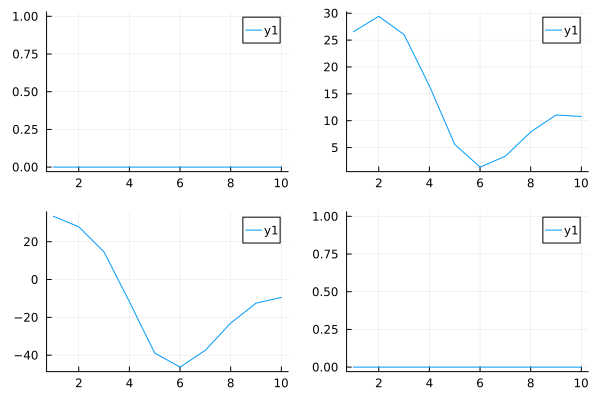

In [120]:
p = []
for i in 1:length(g1[1])
    push!(p, plot(hcat(g1...)[i, :]))
end
plot(p...)

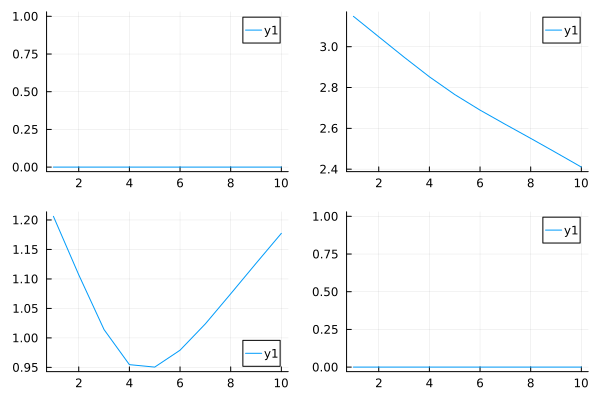

In [121]:
p = []
for i in 1:length(k_phi_estimated_array[1])
    push!(p, plot(hcat(k_phi_estimated_array...)[i, :]))
end
plot(p...)

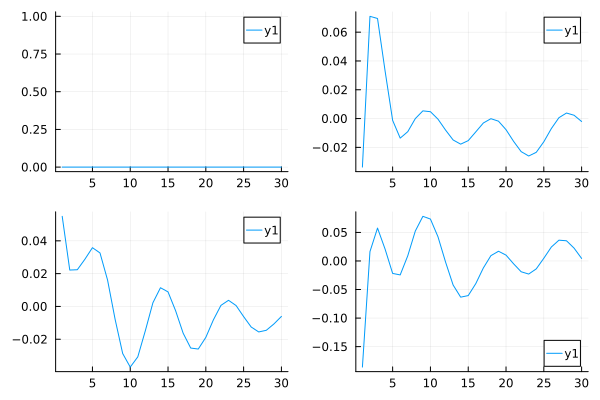

In [102]:
p = []
for i in 1:length(g2[1])
    push!(p, plot(hcat(g2...)[i, :]))
end
plot(p...)

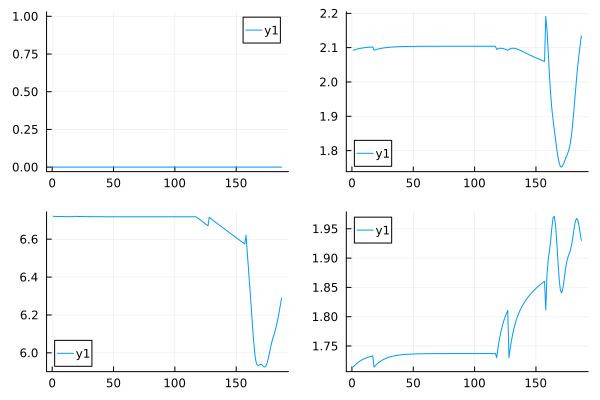

In [103]:
p = []
for i in 1:length(k_psi_estimated_array[1])
    push!(p, plot(hcat(k_psi_estimated_array...)[i, :]))
end
plot(p...)

In [ ]:
plot(loss_train)
plot!(title="Loss")

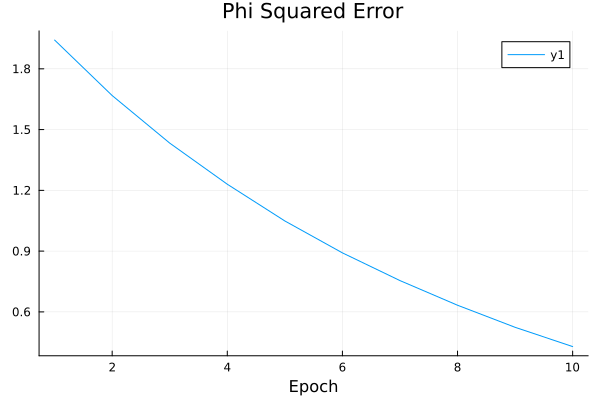

In [128]:
phi_dif = map(i -> (k_phi_estimated_array[i] - ff_phi_target.k) .^ 2, 1:nepoch) |> cpu
psi_dif = map(i -> (k_psi_estimated_array[i] - ff_psi_target.k) .^ 2, 1:nepoch) |> cpu

#二乗誤差
phi_squared_error = map(x -> sum(x), phi_dif)
psi_squared_error = map(x -> sum(x), psi_dif)

phi_dif = [[phi_dif[j][i] for j in 1:nepoch] for i in 1:size(ff_phi_target.k, 1)]
psi_dif = [[psi_dif[j][i] for j in 1:nepoch] for i in 1:size(ff_psi_target.k, 1)]

plot(phi_squared_error, xlabel="Epoch", title="Phi Squared Error")

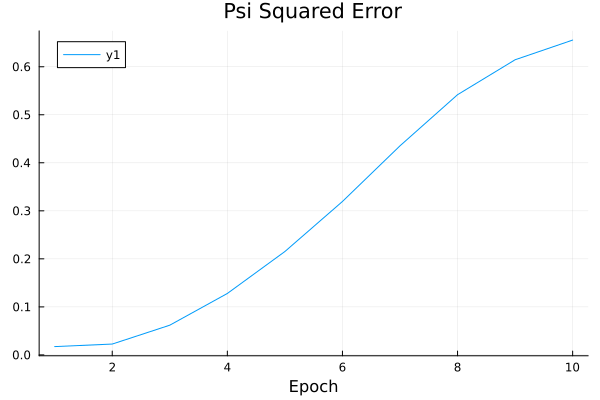

In [129]:
plot(psi_squared_error, xlabel="Epoch", title="Psi Squared Error")

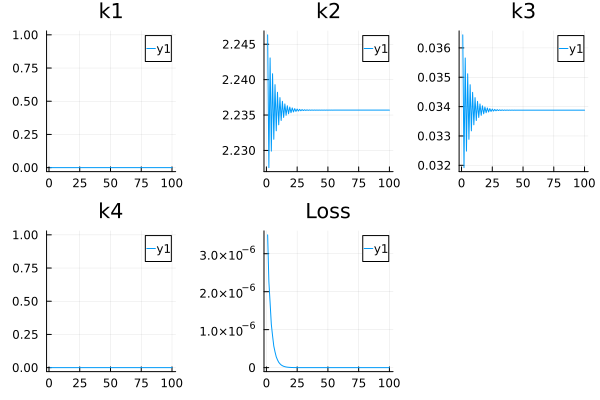

In [58]:
#k_phiと正解の二乗誤差
plt = []
for i in 1:size(ff_phi_target.k, 1)
    tmp = plot()
    plot!(tmp, phi_dif[i], title="k$i")
    push!(plt, tmp)
end
tmp = plot()
plot!(tmp, loss_train, title="Loss")
push!(plt, tmp)

plot(plt...)

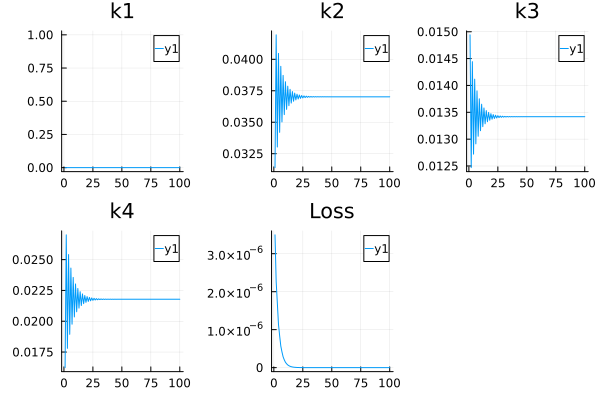

In [59]:
#k_psiと正解の二乗誤差
plt = []
for i in 1:size(ff_psi_target.k, 1)
    tmp = plot()
    plot!(tmp, psi_dif[i], title="k$i")
    push!(plt, tmp)
end
tmp = plot()
plot!(tmp, loss_train, title="Loss")
push!(plt, tmp)

plot(plt...)

In [ ]:
phi_estimated = deepcopy(m.P[1])
psi_estimated = deepcopy(m.P[2])

In [113]:
phi_atom_type = ["protein-C", "protein-N", "protein-CX", "protein-C"]
psi_atom_type = ["protein-N", "protein-CX", "protein-C", "protein-N"]
function create_ff(ff_input_filepath, ff_output_filepath)
    input_xml = readxml(ff_input_filepath)
    output_xml = deepcopy(input_xml)
    xmlroot = root(output_xml)
    children = elements(xmlroot)
    children_name = nodename.(children)
    torsion_index = children_name .== "PeriodicTorsionForce"
    torsion = children[torsion_index][1] #これでtorsion内の要素にアクセスできる

    for ff_params in eachelement(torsion)
        params_name = [nodename(i) for i in eachattribute(ff_params)]
        params_content = [nodecontent(i) for i in eachattribute(ff_params)]
        atom_type = [params_content[params_name .== "type$(i)"][1] for i in 1:4]
        if atom_type == phi_atom_type
            for a in eachattribute(ff_params)
                if occursin(r"k.*", a.name)
                    #ここにkを変える処理を入力
                    index = parse(Int, match(r"\d+", a.name).match)
                    k_updated = phi_estimated[index]
                    a.content = string(k_updated)
                end
            end
            params_name = [nodename(i) for i in eachattribute(ff_params)]
            params_content = [nodecontent(i) for i in eachattribute(ff_params)]
        end
        #ここから処理を書き忘れていたため追加した部分
        if atom_type == psi_atom_type
            for a in eachattribute(ff_params)
                if occursin(r"k.*", a.name)
                    #ここにkを変える処理を入力
                    index = parse(Int, match(r"\d+", a.name).match)
                    k_updated = psi_estimated[index]
                    a.content = string(k_updated)
                end
            end
            params_name = [nodename(i) for i in eachattribute(ff_params)]
            params_content = [nodecontent(i) for i in eachattribute(ff_params)]
        end
        #ここまで
    end
    write(ff_output_filepath, output_xml)
end

create_ff (generic function with 1 method)

In [114]:
nsteps = 250_000_000
gpu_id = "n4"

function run_job(ff_filepath, traj_filepath, log_filepath, i)
    sbatch_file = "temp_$(i).sh"
    
    open(sbatch_file, "w") do of
        println(of, "#!/bin/bash")
        println(of, "#SBATCH -p all")
        println(of, "#SBATCH -J sim$(i) # job name")
        println(of, "#SBATCH -n 1  # num of total mpi processes")
        println(of, "#SBATCH -c 1  # num of threads per mpi processes")
        println(of, "#SBATCH -o $(log_filepath)")
        #println(of, "python sim.py $(pdb_filepath) $(ff_filepath) $(traj_filepath) $(nsteps)")
        println(of, "time python sim.py $(pdb_filepath) $(ff_filepath) $(traj_filepath) $(nsteps)")
    end
    sleep(5)
    run(`sbatch --gpus-per-node=1 -w $(gpu_id) $(sbatch_file)`)
    sleep(5)
    rm(sbatch_file)
end

run_job (generic function with 1 method)

In [116]:
#力場ファイルの作成
#=
estimated_dir = joinpath(ff_dir, "estimated_mean_2_11")
isdir(estimated_dir) || mkdir(estimated_dir)
ff_output_filepath = joinpath(estimated_dir, "estimated_mean_2_11.xml")
create_ff(target_ff_filepath, ff_output_filepath)
=#

In [55]:
#=
#シミュレーションのジョブを流す
for i in 1:10
    ff_filepath = ff_output_filepath
    
    sim_dir = joinpath(estimated_dir, "sim$(i)")
    isdir(sim_dir) || mkdir(sim_dir)
    
    traj_filepath = joinpath(sim_dir, "estimated_$(i)")
    log_filepath = joinpath(sim_dir, "estimated_$(i).log")
    run_job(ff_filepath, traj_filepath, log_filepath, i)
end
=#